In [1]:
%matplotlib notebook
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision.utils import make_grid
import numpy as np

from functools import reduce as func_reduce
from operator import mul as op_mul

#This class contains DatasetClass and several helper functions
import ClassModule as cm

import matplotlib.pyplot as plt
import matplotlib

from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output
sns.set()

device = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cpu


## Setup Tensorboard

In [3]:
#default logdir is "runs"
writer = SummaryWriter('runs/cnn')

## Load data from files

In [4]:
dataset_train = cm.load_data_train()
dataset_test = cm.load_data_test()

## Load it to pytorch `DataLoader`

In [5]:
def get_data(train_ds, test_ds, bs):
    return (
        torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True),
        torch.utils.data.DataLoader(test_ds, batch_size=bs * 2),
    )

In [6]:
Batch_Size =  12 #128

dataloader_train, dataloader_test = get_data(dataset_train, dataset_test, Batch_Size)

## Writing Examples to Tensorboard

In [7]:
#Get one batch of data
dataiter = iter(dataloader_train)
Data = dataiter.next()


sample_Clusters = Data[0]
sample_Features = cm.unsqueeze_features(Data[1])
sample_Labels = Data[2]

sample_ClusterProperties = torch.cat([sample_Features["ClusterE"], sample_Features["ClusterPt"], sample_Features["ClusterM02"]
                                      , sample_Features["ClusterM20"], sample_Features["ClusterDist"]], dim=1)


# create grid
img_grid = make_grid(sample_Clusters[:4])

writer.add_image("Cluster_Examples", img_grid)

In [8]:
#Provide a projector in tensorboard
features = sample_Clusters[:,0,:].view(-1, 20 * 20)
classes = ['bck', 'pi', 'eta']
class_labels = [classes[int(lab.item())] for lab in sample_Labels["PartPID"]]
writer.add_embedding( features, metadata=class_labels, label_img=sample_Clusters[:,0,:].view(-1,1,20,20), tag='cluster')
writer.close()

## Instance Noise

In [9]:
# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = False

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

## Define the network

In [20]:
class CNN(nn.Module):
    def __init__(self, input_dim=(2,20,20), num_in_features=5):
        super(CNN, self).__init__()
        self.feature_ext = nn.Sequential(
            nn.Conv2d(2,10, kernel_size=3, padding=0),
            nn.ReLU(),                             
            nn.Conv2d(10,10, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(10,5, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(5,3, kernel_size=1),
            nn.ReLU()
            )
        
        self.flatten = nn.Flatten()
        
        # Gives the number of features after the conv layer
        num_features_after_conv = func_reduce(op_mul, list(self.feature_ext(torch.rand(1, *input_dim)).shape))
        print("Number of neurons in input layer: {}".format(num_features_after_conv))
        
        self.dense_nn = nn.Sequential(
            nn.Linear(num_features_after_conv + num_in_features, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50,20),
            nn.ReLU(),
            nn.Linear(20,3),
            nn.ReLU()
            )
        
    def forward(self, cluster, clusNumXYEPt):
        cluster = self.feature_ext(cluster)
        x = self.flatten(cluster)
        x = torch.cat([x, clusNumXYEPt], dim=1)
        logits = self.dense_nn(x)
        return logits

In [21]:
device = 'cpu'

In [22]:
model = CNN().to(device)

Number of neurons in input layer: 108


In [13]:
print(model)

CNN(
  (feature_ext): Sequential(
    (0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(5, 3, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_nn): Sequential(
    (0): Linear(in_features=113, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=20, bias=True)
    (9): ReLU()
    (10): Linear(in_features=20, out_features=3, bias=True)
    (11): ReLU()
  )
)


## Model Inspection with tensorboard

In [14]:
writer.add_graph(model, [sample_Clusters, sample_ClusterProperties])
writer.close()

## Set loss function and dataloader

In [15]:
learning_rate = 1e-3

loss_fn = F.cross_entropy

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

## Implement train and test loop
[0: 'ClusterN', 1:'Cluster', 2:'ClusterTiming', 3:'ClusterType', 4:'ClusterE', 5:'ClusterPt', 6:'ClusterModuleNumber', 7:'ClusterRow', 8:'ClusterCol', 9:'ClusterM02', 10:'ClusterM20', 11:'ClusterDistFromVert', 12:'PartE', 13:'PartPt', 14:'PartEta', 15:'PartPhi', 16:'PartIsPrimary', 17:'PartPID']

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, Data in enumerate(dataloader):
        Clusters = Data[0].to(device)
        Features = cm.unsqueeze_features(Data[1])
        Labels = Data[2]
        
        ClusterProperties = torch.cat([Features["ClusterE"], Features["ClusterPt"], Features["ClusterM02"]
                                      , Features["ClusterM20"], Features["ClusterDist"]], dim=1)
        ClusterProperties.to(device)
        
        #if INSTANCE_NOISE:
        #    Cl = add_instance_noise(Cl)
        
        #prediction and loss
        pred = model(Clusters, ClusterProperties)
        loss = loss_fn(pred, Labels["PartPID"].long())
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 9:
            loss, current = loss.item(), batch * len(Features["ClusterE"])
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        

In [17]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for batch, Data in enumerate(dataloader):
            Clusters = Data[0].to(device)
            Features = cm.unsqueeze_features(Data[1])
            Labels = Data[2]
            ClusterProperties = torch.cat([Features["ClusterE"], Features["ClusterPt"], Features["ClusterM02"]
                                      , Features["ClusterM20"], Features["ClusterDist"]], dim=1)           
            ClusterProperties.to(device)
            
            #if INSTANCE_NOISE:
            #    Cl = add_instance_noise(Cl)
            
            pred = model(Clusters, ClusterProperties)
            test_loss += loss_fn(pred, Labels["PartPID"].long()).item()
            correct += (pred.argmax(1) == Labels["PartPID"]).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [18]:
def run_training(epochs, start=0):
    dat=[0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    line1, = ax.plot(dat, label='epoch_loss')
    plt.legend()
    ax.set_xlim([0,epochs])
    fig.canvas.draw()
    for epoch in tqdm(range(start, epochs)):
        print(f"Epoch {epoch+1}\n-------------------------------")
        
        train_loop(dataloader_train, model, loss_fn, optimizer)
        test_loss, _ = test_loop(dataloader_test, model, loss_fn)
        
        if epoch == 0:
            dat = [test_loss]
        else:    
            dat.append(test_loss)
        line1.set_ydata(dat)
        line1.set_xdata(range(len(dat)))
        ax.set_ylim(0, np.max(dat)+1)
        fig.canvas.draw()
        #time.sleep(0.1)
    print("Done!")

<IPython.core.display.Javascript object>


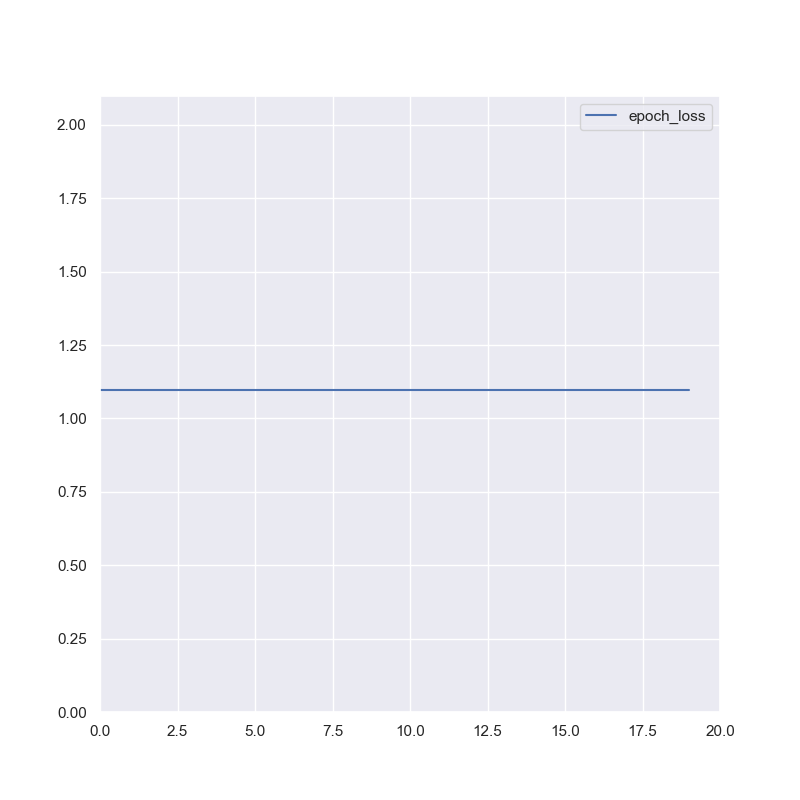

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 2
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 3
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 4
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 5
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 6
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 7
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 8
-------------------------------
loss: 1.098612 [  108/  184]
Test Error: 
 Accuracy: 21.3%, Avg loss: 1.098612 

Epoch 9
------------------------

In [19]:
plt.ion()
run_training(20)